## 1st Trial

In [1]:
import torch
import numpy as np

import torchvision
from torch.utils.data import DataLoader
from torch.backends import mps
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn 
from net_covid19 import Covid19Net
from net_a import ANET
import time


def imshow(img, title=None):
  ''' function to show image '''
  plt.imshow(img.permute(1, 2, 0))
  if title is not None:
    plt.title(title)
  plt.show()

# setup some path variables
project_path = './'
data_path = project_path + 'data/Pneumonia/X-Ray_70-30/'

# select device to run the computations on
if mps.is_available(): # MAcOS with Metal support
    device = torch.device('mps')
elif torch.cuda.is_available(): # Nvidia GPU
    device = torch.device('cuda')
else: # CPU
    device = torch.device('cpu')

# device = torch.device('cpu') # uncomment this line to run on CPU
print(20*"#")
print("Device used: ", device)
print(20*"#")

Covid19Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=93312, out_features=2, bias=True)
)
ANET(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, s

In [20]:

# Define the transformations
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # Resize the image to 224x224
    torchvision.transforms.ToTensor() # Convert the image to a pytorch tensor
])

# Define train / test dataset
train_dataset = torchvision.datasets.ImageFolder(data_path + 'train/', transform=image_transform)
test_dataset = torchvision.datasets.ImageFolder(data_path + 'test/', transform=image_transform)

# Check the classes labels
class_labels = train_dataset.classes
print(class_labels)

# Check the number of samples in the train and test dataset
print('Number of images in train set:', len(train_dataset))
print('Number of images in test set:', len(test_dataset))

# sample_idx = 240
# sample_image, sample_label = train_dataset[sample_idx]
# print(f'Image Shape: {sample_image.shape}')
# print(f'Label: {class_labels[sample_label]}')

# imshow(sample_image)
# sample_image[0,:,:]

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# get a batch of images and labels
images, labels = next(iter(train_loader))
print(f'Shape of image tensors: {images.shape}')
print(f'Shape of label tensors: {labels.shape}')

# Display the batch of images
class_labels_string = ', '.join([class_labels[label] for label in labels]) # Create a string of class labels indexed by labels
# imshow(torchvision.utils.make_grid(images), title = class_labels_string)
# plt.title(class_labels_string)

print(class_labels_string)
print([class_labels[label] for label in labels])

['Bacterial', 'Viral']
Number of images in train set: 11318
Number of images in test set: 4849
Shape of image tensors: torch.Size([16, 3, 224, 224])
Shape of label tensors: torch.Size([16])
Viral, Bacterial, Bacterial, Bacterial, Bacterial, Bacterial, Viral, Bacterial, Bacterial, Bacterial, Bacterial, Viral, Viral, Viral, Viral, Bacterial
['Viral', 'Bacterial', 'Bacterial', 'Bacterial', 'Bacterial', 'Bacterial', 'Viral', 'Bacterial', 'Bacterial', 'Bacterial', 'Bacterial', 'Viral', 'Viral', 'Viral', 'Viral', 'Bacterial']
Covid19Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=93312, out_features=2, bias=True)
)


Covid19Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=93312, out_features=2, bias=True)
)

## Define Hyperparameter, loss function and Train.

In [33]:
# Define the model
# net = Covid19Net()
net = ANET()
print(net)

net.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

num_epochs = 40 # loop over the dataset multiple times

e_ = np.arange(1,num_epochs+1,1)
loss_ = []

start_time = time.time()
for epoch in range(num_epochs): # one epoch is a complete pass through the train dataset
    epoch_loss = 0.0
    for batch_index, data in enumerate(train_loader):
        images, labels = data 
        images, labels = images.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = net(images)
        # outputs = outputs[:,0]
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_.append(epoch_loss)
    print(f'Epoch: {epoch}, Loss: {epoch_loss}') # print the loss every epoch

end_time = time.time()
execution_time = end_time - start_time
print(f"Training completed in {execution_time} seconds")

# torch.save(net.state_dict(), project_path + 'covid19_net.pth')
# net = Covid19Net()
# net.load_state_dict(torch.load(project_path + 'covid19_net.pth'))

torch.save(net.state_dict(), project_path + 'a_net.pth')
net = ANET()
net.load_state_dict(torch.load(project_path + 'a_net.pth'))

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)   
        total += labels.size(0)
        correct += (predicted == labels).sum().item()



print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))
print('Training done on device:', device)

ANET(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=93312, out_features=2, bias=True)
)


KeyboardInterrupt: 

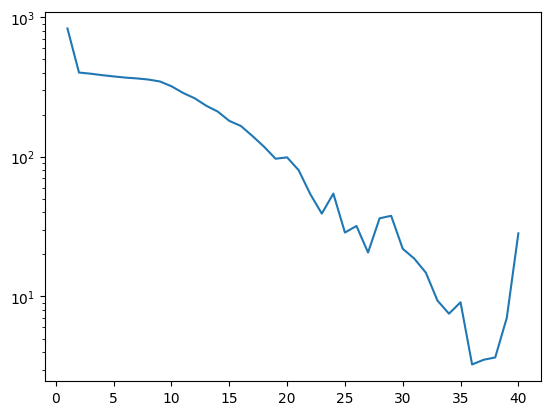

In [30]:

plt.yscale("log")
plt.plot(e_,loss_)
plt.show()


## # Train-Test Size
We re-distribute the train-test split size from 80-20 to 70-30 first, to reduce time in training.
That means from 2 class images we have, 
### 9947 Bacteria and 6221 Viral, we got
### Bacteria Train : 6963, Viral : 4355 = 11318 Train Images
### Bacteria Test : 2984, Viral : 1866 = 4850 Test Images

![images](pneuCLASSreportIMG\covid19net.png)

## # Setting
Start with covid19net from the tutorial to test the workflow

Loss Function = CrossEntropyLoss

Optimizer = Stochastic Gradient Descent

# From the 0
We start simple,


## Epoch = 20, Learning Rate = 0.001
momentum = 0.9

![images](pneuCLASSreportIMG\0_log.png)![images](pneuCLASSreportIMG\0_plt.png)

The loss plot line show shallow slope that is increasing after entering the epoch 13th, which mean we can increase Epoch and learning rate

Accuracy is 99% on test set, which can happen, but with loss this high with CrossEntropyLoss, 
its mean that they maybe outlier that makes the loss value high

*The accuracy on test set is good, but I think we still need to decrease loss further*

## # 1 Increasing Epoch and Learning Rate

#### *We want to see if the loss can continue declining if we increase the epoch to see if its starts to faltten out.*

### Epoch = 40, Learning Rate = 0.0025 

Then, Let's increase epoch to find if the loss slope declines 


![images](pneuCLASSreportIMG\11_log.png)![images](pneuCLASSreportIMG\11_plt.png)


The loss plot still gradually declines but the slope starting to get more shallow, however we increase the epoch number to see if its flattening


## # 1.2
Increasing epoch and learning rate to find where the model stops learning
### Epoch = 60, Learning Rate = 0.003


Even after increasing the epoch to 60, the graph still continue declining

![images](pneuCLASSreportIMG\12_log.png)![images](pneuCLASSreportIMG\12_plt.png)

After try increasing more learning rate, the loss starts exploding.

## # 2 - Add Batch Normalization, Drop Out
The model overfit or not? Let's regularize it by
Normalize input of each layer, Dropout some neurons.
### Epoch = 40, Learning Rate = 0.0025

trying batch normalization, the loss bouncing up and down. and explode around 40 epoch, However, the loss never goes under 1.

BatchNormalization may impact the scale on each layer input, which making the model have difficulties in learning the important features.

![images](pneuCLASSreportIMG\21_log.png)![images](pneuCLASSreportIMG\21_plt.png)

## # 3 - Add layer 3

Add third layer into the neural network input size[3, 16, 32]
### Epoch = 40, Learning rate = 0.0025
First loss gradually decrease.
But there is come jiggering in loss value below 1

![images](pneuCLASSreportIMG\lr001ep40tt7030_3layer.png)
![images](pneuCLASSreportIMG\lr001ep40tt7030lossplot_3layer.png)

Things to change: 
1. Changing Loss Function to weighted cross-entropy loss, focal loss, or Dice loss.
2. Differnet Optimizer Settings 
3. Change learning rate [DONE]
4. Batch Norm (Normalizing input of each layer to ensure distribution of inputs to each layer )
5. Dropout (Preventing overfit?)
6. Data Augmentation (flip image horizontally and vertically)
7. Use of pretrained models like VGGNet, ResNet etc.
8. Segmentation
- Maxpooling remove may increase compute time which may not be efficient to tradeoff